In [293]:
import numpy as np
from numpy import cos, sin, pi

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sympy as sp

In [294]:
# list of DH parameters
# Structure is d, theta, a, alpha in each row

# These parameters are based on the Sixi2 from Marginally Clever

# The theta angles are also referred to as qi

DOF = 6

q1, q2, q3, q4, q5, q6 = sp.symbols('q1 q2 q3 q4 q5 q6')

spi = sp.pi
# Define DH table

DH_params = []

DH_params.append([19.7452, q1, 0, -spi/2])
DH_params.append([0, q2, 35.796, 0])
DH_params.append([0, q3, 6.4259, -spi/2])
DH_params.append([38.705, q4, 0, spi/2])
DH_params.append([0, q5, 0, -spi/2])
DH_params.append([3.795, q6, 0, 0])
DH_params.append([2.75, 0, 0, 0])

DH_params

[[19.7452, q1, 0, -pi/2],
 [0, q2, 35.796, 0],
 [0, q3, 6.4259, -pi/2],
 [38.705, q4, 0, pi/2],
 [0, q5, 0, -pi/2],
 [3.795, q6, 0, 0],
 [2.75, 0, 0, 0]]

In [295]:
# Using the combined DH matrix
def DH_trans_matrix(params):
    
    d, theta, a, alpha = (params[0], params[1], params[2], params[3])
    
    mat = sp.Matrix([[sp.cos(theta), -1*sp.sin(theta)*sp.cos(alpha), sp.sin(theta)*sp.sin(alpha),    a*sp.cos(theta)],
                    [sp.sin(theta), sp.cos(theta)*sp.cos(alpha),    -1*sp.cos(theta)*sp.sin(alpha), a*sp.sin(theta)],
                    [0,             sp.sin(alpha),                  sp.cos(alpha),                  d],
                    [0,             0,                              0,                              1]])
    
    return mat

In [296]:
# Get the transformations from the origin to each of the joints and the end effector
def joint_transforms(DH_params):
    transforms = []

    transforms.append(sp.eye(4)) #Assuming the first first joint is at the origin

    for el in DH_params:

        transforms.append(DH_trans_matrix(el))

    return transforms



In [297]:
# To get the jacobain we can use the cross product method since we have all of the transformations

# Get the total transformation to the end effector
# This function gives the symbolic expression for the jacobian
def jacobian_expr(DH_params):

    transforms = joint_transforms(DH_params)

    trans_EF = transforms[0]

    for mat in transforms[1:]:

        trans_EF = trans_EF * mat

    pos_EF = trans_EF[0:3,3]

    J = sp.zeros(6, DOF)

    for joint in range(DOF):

        trans_joint = transforms[0]

        for mat in transforms[1:joint+1]:

            trans_joint = trans_joint*mat

        z_axis = trans_joint[0:3,2]

        pos_joint = trans_joint[0:3,3]

        Jv = z_axis.cross(pos_EF - pos_joint)

        Jw = z_axis

        J[0:3,joint] = Jv
        J[3:6,joint] = Jw

    J = sp.simplify(J)
    return J

In [298]:
# This function evaluates a symbolic jacobian expression using provided joint angles
def jacobian_subs(joints, jacobian_sym):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    J_l = jacobian_sym
    
    J_l = J_l.subs(q1, joints[0])
    J_l = J_l.subs(q2, joints[1])
    J_l = J_l.subs(q3, joints[2])
    J_l = J_l.subs(q4, joints[3])
    J_l = J_l.subs(q5, joints[4])
    J_l = J_l.subs(q6, joints[5])
    
    return J_l

In [299]:
joints = [0, 0, 0, 0, 0, 0]

jacobian_symbolic = jacobian_expr(DH_params)

jacobian_subs(joints, jacobian_symbolic)

Matrix([
[      0,   -45.25,  -45.25,  0, -6.545,  0],
[42.2219,        0,       0,  0,      0,  0],
[      0, -42.2219, -6.4259,  0,      0,  0],
[      0,        0,       0,  0,      0,  0],
[      0,        1,       1,  0,      1,  0],
[      1,        0,       0, -1,      0, -1]])

In [300]:
def trans_EF_eval(joints, DH_params):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    transforms = joint_transforms(DH_params)

    trans_EF = transforms[0]

    for mat in transforms[1:]:

        trans_EF = trans_EF * mat
    
    trans_EF_cur = trans_EF
    
    trans_EF_cur = trans_EF_cur.subs(q1, joints[0])
    trans_EF_cur = trans_EF_cur.subs(q2, joints[1])
    trans_EF_cur = trans_EF_cur.subs(q3, joints[2])
    trans_EF_cur = trans_EF_cur.subs(q4, joints[3])
    trans_EF_cur = trans_EF_cur.subs(q5, joints[4])
    trans_EF_cur = trans_EF_cur.subs(q6, joints[5])
    
    return trans_EF_cur

In [301]:
def plot_pose(joints, DH_params):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
        
    transforms = joint_transforms(DH_params)

    trans_EF = trans_EF_eval(joints, DH_params)
    
    pos_EF = trans_EF[0:3,3]
    
    xs = []
    ys = []
    zs = []
    
    J = sp.zeros(6, DOF)

    for joint in range(DOF):

        trans_joint = transforms[0]

        for mat in transforms[1:joint+1]:

            trans_joint = trans_joint*mat

        pos_joint = trans_joint[0:3,3]
        
        pos_joint = pos_joint.subs(q1, joints[0])
        pos_joint = pos_joint.subs(q2, joints[1])
        pos_joint = pos_joint.subs(q3, joints[2])
        pos_joint = pos_joint.subs(q4, joints[3])
        pos_joint = pos_joint.subs(q5, joints[4])
        pos_joint = pos_joint.subs(q6, joints[5])
        
        xs.append(pos_joint[0])
        ys.append(pos_joint[1])
        zs.append(pos_joint[2])
        
    xs.append(pos_EF[0])
    ys.append(pos_EF[1])
    zs.append(pos_EF[2])
            
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlim3d(-60,60)
    ax.set_ylim3d(-60,60)
    ax.set_zlim3d(0, 120)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    ax.plot(xs, ys, zs)

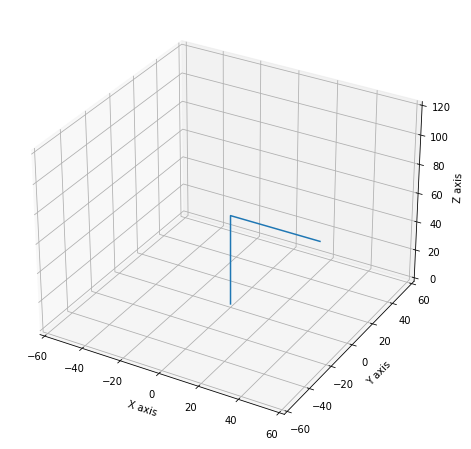

In [302]:
# This is just for testing the robot plotting mechanism

joints = [0, -pi/2, 0, pi/2, 0, 0]

plot_pose(joints, DH_params)

In [303]:
# This takes the current joints and saturates them to the joint limits if they're out of bounds

def joint_limits(joints):
            
    # Joint 1
    if (joints[0] < -2*pi/3):
        
        joints[0] = -2*pi/3
        
    elif (joints[0] > 2*pi/3):
        
        joints[0] = 2*pi/3
        
    
    # Joint 2
    if (joints[1] < -0.95*pi):
        
        joints[1] = -0.95*pi
        
    elif (joints[1] > 0):
        
        joints[1] = 0
        
    # Joint 3
    if (joints[2] < -0.463*pi):
        
        joints[2] = -0.463*pi
        
    elif (joints[2] > 0.48*pi):
        
        joints[2] = 0.48*pi
        
    # Joint 4
    if (joints[3] < -0.97*pi):
        
        joints[3] = -0.97*pi
        
    elif (joints[3] > 0.97*pi):
        
        joints[3] = 0.97*pi
            
    return joints

    # Joint 5
    if (joints[4] < -3*pi/2):
        
        joints[4] = -3*pi/2
        
    elif (joints[4] > 3*pi/2):
        
        joints[4] = 3*pi/2
        
    # Joint 6
    if (joints[5] < -0.95*pi):
        
        joints[5] = -0.95*pi
        
    elif (joints[5] > 0.95*pi):
        
        joints[5] = 0.95*pi
            
    return joints

In [304]:
# joints_init is the current joint values for the robot
# target is the desired transformation matrix at the end effector
# set no_rotation to true if you only care about end effector position, not rotation
# set joint_lims to false if you want to allow the robot to ignore joint limits
# This is currently super slow since it's using all symbolic math
def i_kine(joints_init, target, DH_params, error_trace=False, no_rotation=False, joint_lims=True):
    
    joints = joints_init
    
    xr_desired = target[0:3,0:3]
    xt_desired = target[0:3,3]
    
    x_dot_prev = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        
    e_trace = []
    
    iters = 0;
    
    print("Finding symbolic jacobian")
    
    jacobian_symbolic = jacobian_expr(DH_params)
    
    print("Starting IK loop")
    
    final_xt = 0
    
    while(1):
        
        jac = jacobian_subs(joints, jacobian_symbolic)
        
        jac = np.array(jac).astype(np.float64)
        
        trans_EF_cur = trans_EF_eval(joints, DH_params)
                
        trans_EF_cur = np.array(trans_EF_cur).astype(np.float64)
        
        
        xr_cur = trans_EF_cur[0:3,0:3]
        xt_cur = trans_EF_cur[0:3,3]
        
        final_xt = xt_cur
                
        xt_dot = xt_desired - xt_cur
        
        #print(xr_cur)
        #print(np.linalg.norm(xr_cur))
        
        # Find error rotation matrix
        R = xr_desired @ xr_cur.T
        
        #print(R)
                            
        # convert to angular velocity
        v = np.arccos((R[0,0] + R[1,1] + R[2,2] - 1)/2)
        r = (0.5 * sin(v)) * np.array([[R[2,1]-R[1,2]],
                                       [R[0,2]-R[2,0]],
                                       [R[1,0]-R[0,1]]])
        
        #print(v, r)
        
        xr_dot = 200 * r * sin(v)
        
        # use this if you only care about end effector position and not rotation
        if (no_rotation):
            
            xr_dot = 0 * r
        
        xt_dot = xt_dot.reshape((3,1))
                
        x_dot = np.vstack((xt_dot, xr_dot))
        
        #print(x_dot)
        
        x_dot_norm = np.linalg.norm(x_dot)
        
        #print(x_dot_norm)
        
        if (x_dot_norm > 25):
            
            x_dot /= (x_dot_norm/25)
            
        x_dot_change = np.linalg.norm(x_dot - x_dot_prev)
        
        #print(x_dot_change)
            
        if (x_dot_change < 0.001):
            
            break;
            
        x_dot_prev = x_dot
            
        e_trace.append(x_dot_norm)
            
        Lambda = 10
        Alpha = 1
                        
        joint_change = Alpha * np.linalg.inv(jac.T@jac + Lambda**2*np.eye(DOF)) @ jac.T @ x_dot
        
        joints += joint_change
        
        if (joint_lims): joints = joint_limits(joints)
        
        iters += 1
        
        #print(" ")
        
    print("Done in {} iterations".format(iters))
    
    print("Final position is:")
    print(final_xt)
        
    return (joints, e_trace) if error_trace else joints

Finding symbolic jacobian
Starting IK loop
Done in 196 iterations
Final position is:
[ 3.99997213e+01 -1.05929943e-03  1.99994391e+01]


Text(0.5, 1.0, 'Error Trace')

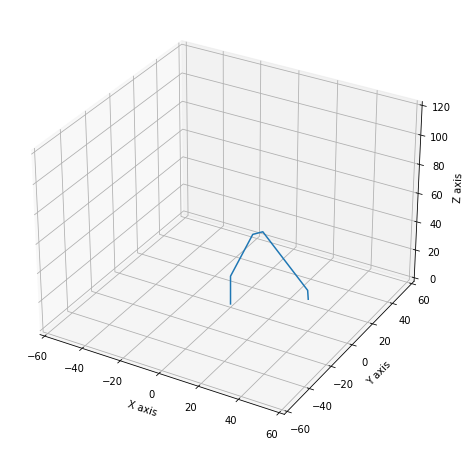

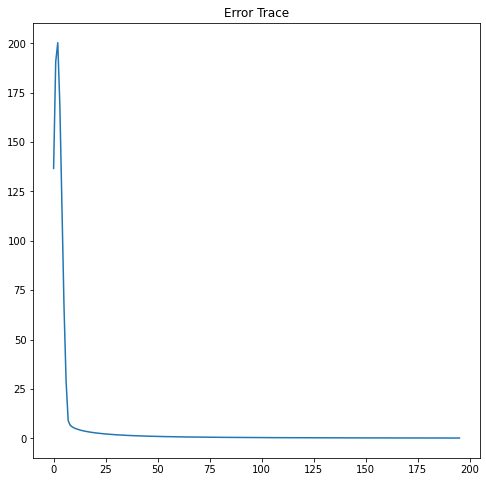

In [305]:
joints = np.array([[0.0],[-pi/2],[0.0],[pi/2],[0.0],[0.0]])

target = np.array([[1, 0, 0, 40],
                   [0, -1, 0, 0],
                   [0, 0, -1, 20],
                   [0, 0, 0, 1]])

new_j, e_trace = i_kine(joints, target, DH_params, error_trace=True)

plot_pose(new_j, DH_params)

plt.figure(figsize=(8,8))
plt.plot(e_trace)
plt.title('Error Trace')

Finding symbolic jacobian
Starting IK loop
Done in 12 iterations
Final position is:
[6.62049548e+01 7.74259227e-04 6.72755050e+01]


Text(0.5, 1.0, 'Error Trace')

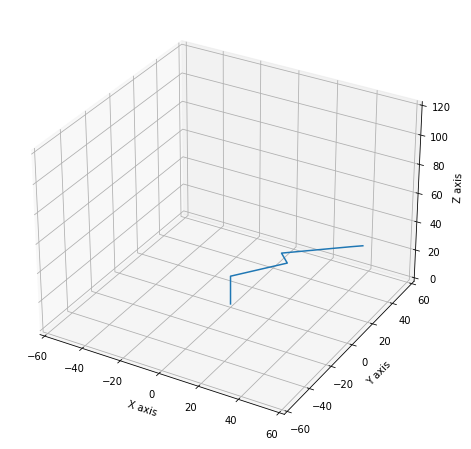

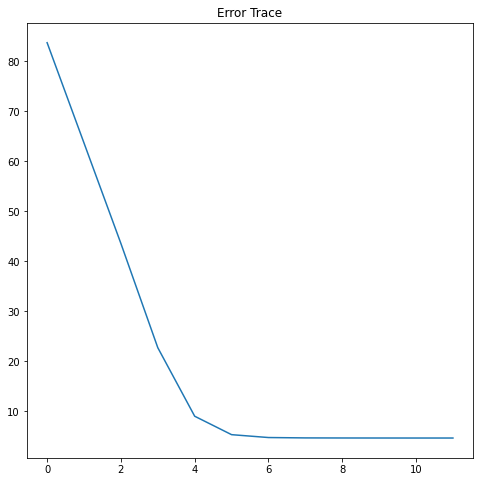

In [55]:
joints = np.array([[pi/2],[-pi/2],[0.0],[pi/2],[0.0],[0.0]])

target = np.array([[1, 0, 0, 70],
                   [0, -1, 0, 0],
                   [0, 0, -1, 70],
                   [0, 0, 0, 1]])

new_j, e_trace = i_kine(joints, target, DH_params, error_trace=True, no_rotation=True)

plot_pose(new_j, DH_params)

plt.figure(figsize=(8,8))
plt.plot(e_trace)
plt.title('Error Trace')